In [53]:
import pandas as pd
import json
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

In [2]:
DATA_FILE = 'date_imobiliare.txt'

In [3]:
data = []
with open(DATA_FILE, 'rt') as fin:
    for line in fin:
        data.append(json.loads(line))

In [4]:
def parse_commision(commision):
    if commision.strip() == '':
        return float('nan')
    try:
        return re.match(r'\D*(\d+)\D*', commision).group(1)
    except:
        return float('nan')

In [5]:
def parse_characteristics(characteristics):
    rooms = float('nan')
    size = float('nan')
    floor = float('nan')
    decomandat = float('nan')
    nou = float('nan')
    
    for char in characteristics:
        if 'camera' in char:
            rooms = 0
        elif 'camere' in char:
            try:
                rooms = float(re.match(r'\D*(\d+)\s*camere.*', char).group(1))
            except:
                pass
        
        if 'mp' in char:
            try:
                size = float(re.match(r'\D*(\d+\.?\d+)\s*mp.*', char).group(1))
            except:
                pass
        
        if 'semidecomandat' in char.lower():
            decomandat = 1
        elif 'decomandat' in char.lower():
            decomandat = 2
            
        if 'parter' in char.lower():
            floor = 0
        elif 'etaj' in char.lower():
            try:
                floor = int(re.match(r'.*etaj\s*(\d+)', char.lower()).group(1))
            except:
                pass
    
        if 'nou' in char.lower():
            nou = True
        elif 'vechi' in char.lower():
            nou = False

    return rooms, size, floor, decomandat, nou

In [6]:
def parse_currency(currency):
    if 'eur' in currency.lower():
        return 'EUR'
    return ''

In [1]:
def parse_price(price):
    price = price.replace('.', '')
    price = price.replace(',', '')
    try:
        return float(price)
    except:
        return float('nan')

In [2]:
data[0]

NameError: name 'data' is not defined

In [9]:
parsed_data = []
for e in data:
    title = e['title']
    price = parse_price(e['price'])
    currency = parse_currency(e['currency'])
    commision = parse_commision(e['commision'])
    rooms, size, floor, decomandat, new = parse_characteristics(e['characteristics'])
    
    parsed_data.append({
        'title': title,
        'price': price,
        'currency': currency,
        'commission': commision,
        'rooms': rooms,
        'size': size,
        'floor': floor,
        'decomandat': decomandat,
        'new': new
    })

In [10]:
parsed_data[0]

{'title': 'Apartament 3 camere Baneasa-Pipera La GLOIRE, pe malul lacului',
 'price': 100999.0,
 'currency': 'EUR',
 'commission': '0',
 'rooms': 3.0,
 'size': 86.63,
 'floor': 2,
 'decomandat': 2,
 'new': True}

In [11]:
df = pd.DataFrame.from_records(parsed_data)
df.head()

,commission,currency,decomandat,floor,new,price,rooms,size,title
0,0,EUR,2.0,2.0,True,100999.0,3.0,86.63,"Apartament 3 camere Baneasa-Pipera La GLOIRE, ..."
1,0,EUR,2.0,2.0,True,39900.0,2.0,48.00,2 Camere Finalizate la cheie 39.900 Euro cu Lo...
2,0,EUR,2.0,4.0,True,620000.0,5.0,200.00,"Luxury Apartments | 4 bedrooms with Park view,..."
3,0,EUR,2.0,8.0,True,650000.0,4.0,211.00,"Vedere panoramica lac! 4 camere, terasa, 290mp..."
4,0,EUR,1.0,2.0,True,157000.0,2.0,65.42,49 Gafencu | Luxury concept apartments | 1 bed...


In [12]:
df['currency'].value_counts()

EUR    3979
         51
Name: currency, dtype: int64

In [13]:
del df['currency']

In [14]:
df['commission'].value_counts()

0    2567
Name: commission, dtype: int64

In [15]:
df['commission'] = df['commission'].fillna(0)
df['decomandat'] = df['decomandat'].fillna(0)
df['floor'] = df['floor'].fillna(-1)
df['new'] = df['new'].fillna(False)

In [16]:
print('Before n/a drop:', df.shape)
df = df.dropna()
print('After n/a drop:', df.shape)

Before n/a drop: (4030, 8)
After n/a drop: (3556, 8)


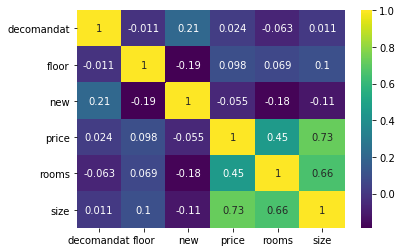

In [17]:
sns.heatmap(df.corr(), cmap=plt.cm.viridis, annot=True)
plt.show()

In [18]:
X = np.matrix(df[['rooms', 'size']])
y = np.array(df['price'])

kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]
    
    model = LinearRegression(normalize=True)
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    
    print('[Split %d] Score: %f' % (split, score))

[Split 0] Score: 115559.855729
[Split 1] Score: 96005.403221
[Split 2] Score: 78731.006242
[Split 3] Score: 98540.429610
[Split 4] Score: 74787.324590


In [19]:
X = np.matrix(df[['rooms', 'size', 'new', 'decomandat', 'floor']])
y = np.array(df['price'])

kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]
    
    model = LinearRegression(normalize=True)
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    
    print('[Split %d] Score: %f' % (split, score))

[Split 0] Score: 115331.736786
[Split 1] Score: 96035.449300
[Split 2] Score: 78313.861824
[Split 3] Score: 98771.764504
[Split 4] Score: 77175.169079


/opt/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


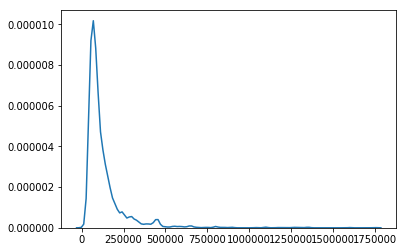

In [20]:
sns.kdeplot(y)
plt.show()

In [21]:
X = np.matrix(df.loc[df['price'] < 300000][['rooms', 'size']])
y = np.array(df.loc[df['price'] < 300000]['price'])

kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]
    
    model = LinearRegression(normalize=True)
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    
    print('[Split %d] Score: %f' % (split, score))

[Split 0] Score: 39453.875820
[Split 1] Score: 42236.005708
[Split 2] Score: 40549.450425
[Split 3] Score: 52682.620407
[Split 4] Score: 41276.426672


/opt/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


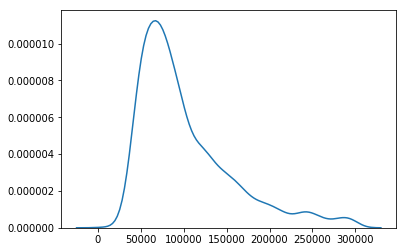

In [22]:
sns.kdeplot(y)
plt.show()

In [23]:
df.loc[df['price'] < 300000]['price'].describe()

count      3307.000000
mean     102499.993347
std       55404.713087
min        5000.000000
25%       63000.000000
50%       85000.000000
75%      127000.000000
max      299900.000000
Name: price, dtype: float64

In [25]:
X = np.matrix(df.loc[df['price'] < 150000].loc[df['price'] > 50000][['rooms', 'size']])
y = np.array(df.loc[df['price'] < 150000].loc[df['price'] > 50000][['price']])
models = []

kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]
    
    model = LinearRegression(normalize=True)
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    models.append(model)
    print('[Split %d] Score: %f' % (split, score))

[Split 0] Score: 24066.808637
[Split 1] Score: 24226.502154
[Split 2] Score: 22960.407509
[Split 3] Score: 23214.149965
[Split 4] Score: 22170.167075


In [65]:
X = np.array(df.loc[df['price'] < 150000].loc[df['price'] > 50000][['size']])
y = np.array(df.loc[df['price'] < 150000].loc[df['price'] > 50000][['price']])
models = []

kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]
    
    model = LinearRegression(normalize=True)
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    models.append(model)
    print('[Split %d] Score: %f' % (split, score))

[Split 0] Score: 24428.477083
[Split 1] Score: 24149.549595
[Split 2] Score: 23189.599275
[Split 3] Score: 23550.299524
[Split 4] Score: 22006.233609


In [83]:
model = LinearRegression(normalize=True)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [84]:
model.coef_, model.intercept_

(array([[616.79754917]]), array([44965.51534711]))

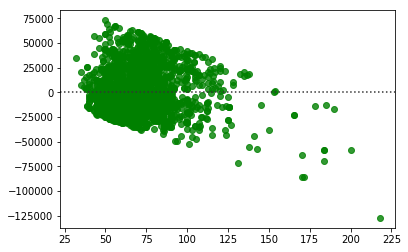

In [73]:
sns.residplot(X[:, 0], y, color='g')

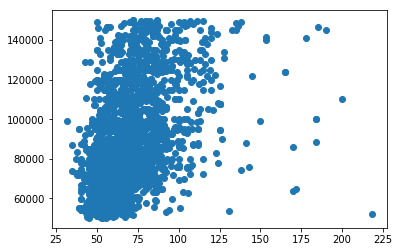

In [76]:
plt.scatter(X, y)
plt.show()